## Εισαγωγικά

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn 
import scipy.stats

In [2]:
# Set random seed for reproducibility
import random
import os
SEED = 56
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)

from sklearn.utils import check_random_state
check_random_state(SEED)

RandomState(MT19937) at 0x1AE3C9D2440

In [3]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## Β. Προεπεξεργασία και Εξερεύνηση Δεδομένων

### 1. Εξερευνητική Ανάλυση Δεδομένων (EDA)

In [4]:
# Load data with pickling enabled
data = np.load(r'C:\\Users\\vasgk\\Desktop\\Μηχανική μάθηση\\Data\\breastmnist_224.npz', allow_pickle=True)

# Inspect the keys in the dataset
print("Keys in the dataset:", data.files)
print("Shape of file contents: (no of contents, dimensions (224x224))")

# Print the shape of each file in the original npz file
for key in data.files:
    print(f"{key}: {data[key].shape}")

Keys in the dataset: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']
Shape of file contents: (no of contents, dimensions (224x224))
train_images: (546, 224, 224)
train_labels: (546, 1)
val_images: (78, 224, 224)
val_labels: (78, 1)
test_images: (156, 224, 224)
test_labels: (156, 1)


In [5]:
# Convert the data into a DataFrame
# Flatten the images and combine them with labels
# Flatten the images and combine them with labels
train_images_flat = data['train_images'].reshape(len(data['train_images']), -1)  # Flatten 224x224 images
df_train = pd.DataFrame(train_images_flat)
df_train['Label'] = data['train_labels']

# Repeat for validation and test data, but in reverse order because the dataset's ratio is reversed
val_images_flat = data['test_images'].reshape(len(data['test_images']), -1)
df_val = pd.DataFrame(val_images_flat)
df_val['Label'] = data['test_labels']

test_images_flat = data['val_images'].reshape(len(data['val_images']), -1)
df_test = pd.DataFrame(test_images_flat)
df_test['Label'] = data['val_labels']

# Split the data into features and labels for the rest of the code
x_train = df_train.drop(columns=['Label']).values  
y_train = df_train['Label'].values.ravel()  
x_val = df_val.drop(columns=['Label']).values 
y_val = df_val['Label'].values.ravel()  
x_test = df_test.drop(columns=['Label']).values  
y_test = df_test['Label'].values.ravel()  

## Ε. Βαθιά Νευρωνικά Δίκτυα

### MLP

Using device: cuda
Epoch [10/20], Loss: 95.3304, Train Accuracy: 64.29%, Validation Accuracy: 74.36%, Test Accuracy: 75.64%
Epoch [20/20], Loss: 1.1566, Train Accuracy: 40.66%, Validation Accuracy: 34.62%, Test Accuracy: 34.62%


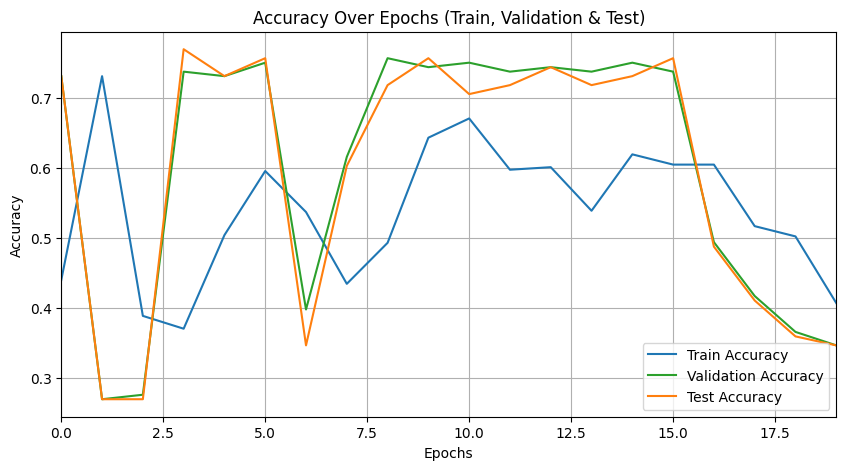

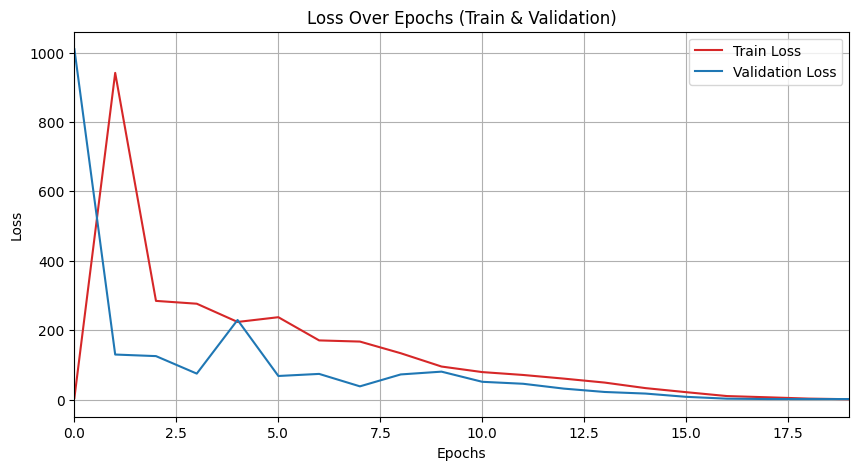

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.29      1.00      0.45        21
           1       1.00      0.11      0.19        57

    accuracy                           0.35        78
   macro avg       0.65      0.55      0.32        78
weighted avg       0.81      0.35      0.26        78



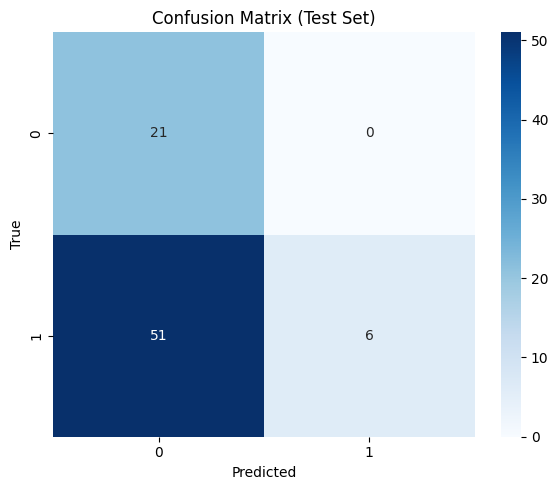

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Κωδικοποίηση των ετικετών σε αριθμητική μορφή
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Increase the weight for class 0 to maximize its recall
weight_for_0 = 3.0  # Try 2.0, 3.0, 5.0, etc.
weight_for_1 = 1.0
weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float32).to(device)

# Δημιουργία του μοντέλου MLP με κανονικοποίηση (Dropout και L2 regularization)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.dropout(x)
        x = self.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.output(x)
        return x

# Ορισμός παραμέτρων μοντέλου
input_size = x_train.shape[1]  # Από το PCA
hidden_size = 128
output_size = len(set(y_train_encoded))

# Δημιουργία του μοντέλου
dropout_rate = 0.3  # Ορισμός του dropout
model = MLP(input_size, hidden_size, output_size, dropout_rate)

# Ορισμός του device (GPU ή CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
model.to(device)

# Μεταφορά των δεδομένων στην GPU
X_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long).to(device)

# Ορισμός της συνάρτησης κόστους και του optimizer
criterion = nn.CrossEntropyLoss(weight=weights)  # Χρήση του CrossEntropyLoss για πολυκατηγορηματική ταξινόμηση
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Adam optimizer με L2 regularization (weight_decay)

# Εκπαίδευση του μοντέλου
num_epochs = 20
train_losses = []  # Απώλεια εκπαίδευσης
val_losses = []  # Απώλεια validation
train_accuracies = []  # Ακρίβεια εκπαίδευσης
val_accuracies = []  # Ακρίβεια validation
test_accuracies = []  # Ακρίβεια test

for epoch in range(num_epochs):
    model.train()
    
    # Forward pass για τα δεδομένα εκπαίδευσης
    outputs = model(X_train_tensor)
    _, predicted = torch.max(outputs, 1)
    train_accuracy = accuracy_score(y_train_tensor.cpu(), predicted.cpu())
    train_accuracies.append(train_accuracy)

    # Υπολογισμός απώλειας
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Αποθήκευση της τιμής της απώλειας
    train_losses.append(loss.item())

    # Υπολογισμός και αποθήκευση της ακρίβειας για το validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())  # Αποθήκευση της απώλειας του validation set
        
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_val_tensor.cpu(), val_predicted.cpu())
        val_accuracies.append(val_accuracy)

        # Υπολογισμός και αποθήκευση της ακρίβειας για το test set
        test_outputs = model(X_test_tensor)
        _, test_predicted = torch.max(test_outputs, 1)
        test_accuracy = accuracy_score(y_test_tensor.cpu(), test_predicted.cpu())
        test_accuracies.append(test_accuracy)

    # Εκτύπωση της απώλειας και ακρίβειας κάθε 10 εποχές
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
              f'Train Accuracy: {train_accuracy * 100:.2f}%, '
              f'Validation Accuracy: {val_accuracy * 100:.2f}%, '
              f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Γράφημα με τις Ακρίβειες
plt.figure(figsize=(10, 5))

# Καμπύλες για την ακρίβεια
plt.plot(range(num_epochs), train_accuracies, color='tab:blue', label='Train Accuracy')
plt.plot(range(num_epochs), val_accuracies, color='tab:green', label='Validation Accuracy')
plt.plot(range(num_epochs), test_accuracies, color='tab:orange', label='Test Accuracy')

# Ρυθμίσεις
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs (Train, Validation & Test)')
plt.legend(loc='lower right')
plt.grid(True)

# Ρύθμιση του άξονα x για να ξεκινάει από 0 και να τελειώνει στο num_epochs - 1
plt.xlim(0, num_epochs - 1)  # Εξασφαλίζουμε ότι το γράφημα τελειώνει στην τελευταία εποχή (20)

plt.show()

# Γράφημα με τις Απώλειες
plt.figure(figsize=(10, 5))

# Καμπύλες για την απώλεια
plt.plot(range(num_epochs), train_losses, color='tab:red', label='Train Loss')
plt.plot(range(num_epochs), val_losses, color='tab:blue', label='Validation Loss')

# Ρυθμίσεις
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs (Train & Validation)')
plt.legend(loc='upper right')
plt.grid(True)

# Ρύθμιση του άξονα x για να ξεκινάει από 0 και να τελειώνει στο num_epochs - 1
plt.xlim(0, num_epochs - 1)  # Εξασφαλίζουμε ότι το γράφημα τελειώνει στην τελευταία εποχή (20)
plt.show()

# Get predictions for the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    y_pred_test = torch.argmax(test_outputs, dim=1).cpu().numpy()

# Classification report
print("Classification Report (Test Set):")
print(classification_report(y_test_tensor.cpu().numpy(), y_pred_test, target_names=[str(c) for c in label_encoder.classes_]))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_tensor.cpu().numpy(), y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Κωδικοποίηση των ετικετών σε αριθμητική μορφή
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

class_names = [str(c) for c in label_encoder.classes_]

best_recall_0 = 0
best_weight = weight_for_0  
best_score = -1
best_model = None

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate, activation_function):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        in_size = input_size
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(in_size, hidden_size))
            self.layers.append(activation_function)
            self.layers.append(nn.Dropout(dropout_rate))
            in_size = hidden_size
        self.output = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output(x)
        return x

# Try different weights for class 0
for weight_for_0 in [1.0, 2.0, 3.0, 5.0, 10.0]:
    weights = torch.tensor([weight_for_0, 1.0], dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    
    # Define and train a simple model for a few epochs (or use your main loop)
    model = MLP(input_size, [128, 64], output_size, 0.3, nn.ReLU()).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    
    for epoch in range(5):  # Use fewer epochs for speed
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        y_pred_val = torch.argmax(val_outputs, dim=1).cpu().numpy()
        recall_0 = recall_score(y_val_tensor.cpu().numpy(), y_pred_val, pos_label=0)
        acc = accuracy_score(y_val_tensor.cpu().numpy(), y_pred_val)
        score = 0.7 * recall_0 + 0.3 * acc  # adjust weights as you prefer
        print(f"Weight {weight_for_0}: recall_0={recall_0:.3f}, acc={acc:.3f}, combined={score:.3f}")
        if score > best_score:
            best_score = score
            best_model = model 

print(f"Best weight for class 0: {best_weight}, Best recall for class 0: {best_recall_0:.4f}")

# Δημιουργία του μοντέλου MLP με κανονικοποίηση (Dropout και L2 regularization)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate, activation_function):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        in_size = input_size
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(in_size, hidden_size))
            self.layers.append(activation_function)  # Συναρτήσεις ενεργοποίησης
            self.layers.append(nn.Dropout(dropout_rate))  # Dropout μετά από κάθε κρυφό επίπεδο
            in_size = hidden_size
        self.output = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output(x)
        return x

# Ορισμός του criterion (συνάρτηση κόστους)
weights = torch.tensor([best_weight, 1.0], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

# Δημιουργία και εκπαίδευση με διαφορετικές υπερπαραμέτρους
activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.Tanh()]  # Πειραματισμός με συναρτήσεις ενεργοποίησης
hidden_layers_options = [[128, 64], [256, 128], [64, 64, 32]]  # Διάφοροι αριθμοί κρυφών επιπέδων
learning_rates = [0.001, 0.0001, 0.01]  # Διάφοροι ρυθμοί μάθησης
dropout_rates = [0.3, 0.5]  # Διαφορετικοί ρυθμοί dropout

# Αποθήκευση των αποτελεσμάτων για σύγκριση
results = {}

# Ορισμός παραμέτρων μοντέλου
input_size = x_train.shape[1]  # Από το PCA
output_size = len(set(y_train_encoded))  # Από τον αριθμό των κατηγοριών

best_model = None
best_val_accuracy = 0

# Εκπαίδευση με διαφορετικές παραμέτρους
for activation_function in activation_functions:
    for hidden_layers in hidden_layers_options:
        for lr in learning_rates:
            for dropout_rate in dropout_rates:
                
                # Δημιουργία του μοντέλου με τις τρέχουσες υπερπαράμετρους
                model = MLP(input_size, hidden_layers, output_size, dropout_rate, activation_function).to(device)
                
                # Ορισμός του optimizer και της συνάρτησης κόστους
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)  # L2 regularization
                
                # Εκπαίδευση του μοντέλου
                num_epochs = 20
                train_losses = []
                val_losses = []
                train_accuracies = []
                val_accuracies = []
                test_accuracies = []

                for epoch in range(num_epochs):
                    model.train()

                    # Forward pass για τα δεδομένα εκπαίδευσης
                    outputs = model(X_train_tensor)
                    _, predicted = torch.max(outputs, 1)
                    train_accuracy = accuracy_score(y_train_tensor.cpu(), predicted.cpu())
                    train_accuracies.append(train_accuracy)

                    # Υπολογισμός απώλειας
                    loss = criterion(outputs, y_train_tensor)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    # Αποθήκευση της τιμής της απώλειας
                    train_losses.append(loss.item())

                    # Υπολογισμός και αποθήκευση της ακρίβειας για το validation set
                    model.eval()
                    with torch.no_grad():
                        val_outputs = model(X_val_tensor)
                        val_loss = criterion(val_outputs, y_val_tensor)
                        val_losses.append(val_loss.item())  # Αποθήκευση της απώλειας του validation set

                        _, val_predicted = torch.max(val_outputs, 1)
                        val_accuracy = accuracy_score(y_val_tensor.cpu(), val_predicted.cpu())
                        val_accuracies.append(val_accuracy)

                                               
                        recall_0 = recall_score(y_val_tensor.cpu().numpy(), val_predicted.cpu().numpy(), pos_label=0)
                        combined_score = 0.7 * recall_0 + 0.3 * val_accuracy
                         

                    if combined_score > best_val_accuracy:
                        best_val_accuracy = combined_score
                        best_model = model
                        best_hyperparameters = (str(hidden_layers), activation_function.__class__.__name__, lr, dropout_rate)
                        best_result = {
                            'train_losses': train_losses.copy(),
                            'val_losses': val_losses.copy(),
                            'train_accuracies': train_accuracies.copy(),
                            'val_accuracies': val_accuracies.copy()
                }

                        # Υπολογισμός και αποθήκευση της ακρίβειας για το test set
                        test_outputs = model(X_test_tensor)
                        _, test_predicted = torch.max(test_outputs, 1)
                        test_accuracy = accuracy_score(y_test_tensor.cpu(), test_predicted.cpu())
                        test_accuracies.append(test_accuracy)

                    # Εκτύπωση της απώλειας και ακρίβειας κάθε 10 εποχές
                    if (epoch+1) % 10 == 0:
                        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
                              f'Train Accuracy: {train_accuracy * 100:.2f}%, '
                              f'Validation Accuracy: {val_accuracy * 100:.2f}%, '
                              f'Test Accuracy: {test_accuracy * 100:.2f}%')

                # Αποθήκευση του μοντέλου με την καλύτερη ακρίβεια validation
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_model = model
                    best_hyperparameters = (str(hidden_layers), activation_function.__class__.__name__, lr, dropout_rate)
                    best_result = {
                        'train_losses': train_losses.copy(),
                        'val_losses': val_losses.copy(),
                        'train_accuracies': train_accuracies.copy(),
                        'val_accuracies': val_accuracies.copy()
                    }

                # Αποθήκευση των αποτελεσμάτων για σύγκριση
                results[(str(hidden_layers), str(activation_function), lr, dropout_rate)] = {
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_accuracies': train_accuracies,
                    'val_accuracies': val_accuracies,
                    'test_accuracies': test_accuracies,
                    'model': model  # Προσθήκη του μοντέλου στο dictionary
                }

# Εκτύπωση των βέλτιστων υπερπαραμέτρων
print(f'Best Hyperparameters: {best_hyperparameters}')

Weight 1.0: recall_0=0.000, acc=0.731, combined=0.219
Weight 2.0: recall_0=1.000, acc=0.269, combined=0.781
Weight 3.0: recall_0=0.929, acc=0.378, combined=0.763
Weight 5.0: recall_0=0.071, acc=0.699, combined=0.260
Weight 10.0: recall_0=1.000, acc=0.269, combined=0.781
Best weight for class 0: 3.0, Best recall for class 0: 0.0000
Epoch [10/20], Loss: 133.7221, Train Accuracy: 56.78%, Validation Accuracy: 73.08%, Test Accuracy: 26.92%
Epoch [20/20], Loss: 73.0550, Train Accuracy: 60.44%, Validation Accuracy: 75.00%, Test Accuracy: 26.92%
Epoch [10/20], Loss: 45.8402, Train Accuracy: 62.82%, Validation Accuracy: 76.28%, Test Accuracy: 28.21%
Epoch [20/20], Loss: 0.6933, Train Accuracy: 32.78%, Validation Accuracy: 26.92%, Test Accuracy: 28.21%
Epoch [10/20], Loss: 17.0686, Train Accuracy: 51.10%, Validation Accuracy: 42.31%, Test Accuracy: 38.46%
Epoch [20/20], Loss: 11.2775, Train Accuracy: 51.83%, Validation Accuracy: 72.44%, Test Accuracy: 38.46%
Epoch [10/20], Loss: 13.0417, Train A

Test Loss: 4.0732


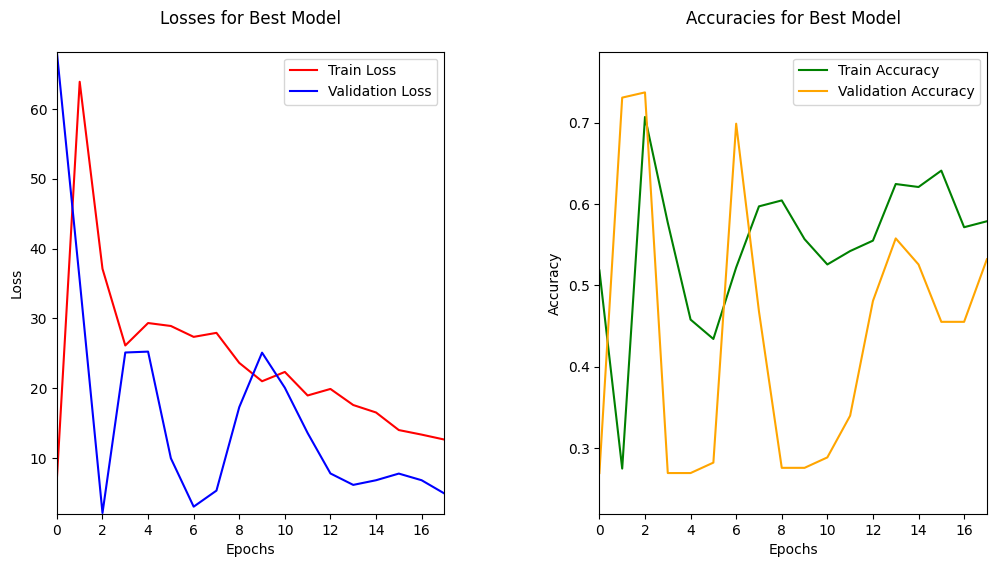

In [8]:
# Υπολογισμός του Test Loss (χωρίς να το εμφανίσουμε στα γραφήματα)
with torch.no_grad():
    test_outputs = best_model(X_test_tensor)  # Υπολογισμός εξόδου για το test set
    test_loss = criterion(test_outputs, y_test_tensor).item()  # Υπολογισμός του Test Loss

# Εκτύπωση του Test Loss για το καλύτερο μοντέλο
print(f'Test Loss: {test_loss:.4f}')

# Οπτικοποίηση των αποτελεσμάτων χωρίς το Test Loss και Test Accuracy
plt.figure(figsize=(12, 6))

# Find the minimum length for each metric to avoid shape mismatch
min_len_loss = min(len(best_result['train_losses']), len(best_result['val_losses']))
min_len_acc = min(len(best_result['train_accuracies']), len(best_result['val_accuracies']))

# Γράφημα για τις Απώλειες του καλύτερου μοντέλου
plt.subplot(1, 2, 1)
plt.plot(range(min_len_loss), best_result['train_losses'][:min_len_loss], label='Train Loss', color='red')
plt.plot(range(min_len_loss), best_result['val_losses'][:min_len_loss], label='Validation Loss', color='blue')
plt.title(f'Losses for Best Model', pad=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xlim(0, min_len_loss-1)
plt.ylim(
    min(best_result['train_losses'][:min_len_loss] + best_result['val_losses'][:min_len_loss]) - 0.1,
    max(best_result['train_losses'][:min_len_loss] + best_result['val_losses'][:min_len_loss]) + 0.1
)

# Γράφημα για τις Ακρίβειες του καλύτερου μοντέλου
plt.subplot(1, 2, 2)
plt.plot(range(min_len_acc), best_result['train_accuracies'][:min_len_acc], label='Train Accuracy', color='green')
plt.plot(range(min_len_acc), best_result['val_accuracies'][:min_len_acc], label='Validation Accuracy', color='orange')
plt.title(f'Accuracies for Best Model', pad=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim(0, min_len_acc-1)
plt.ylim(
    min(best_result['train_accuracies'][:min_len_acc] + best_result['val_accuracies'][:min_len_acc]) - 0.05,
    max(best_result['train_accuracies'][:min_len_acc] + best_result['val_accuracies'][:min_len_acc]) + 0.05
)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

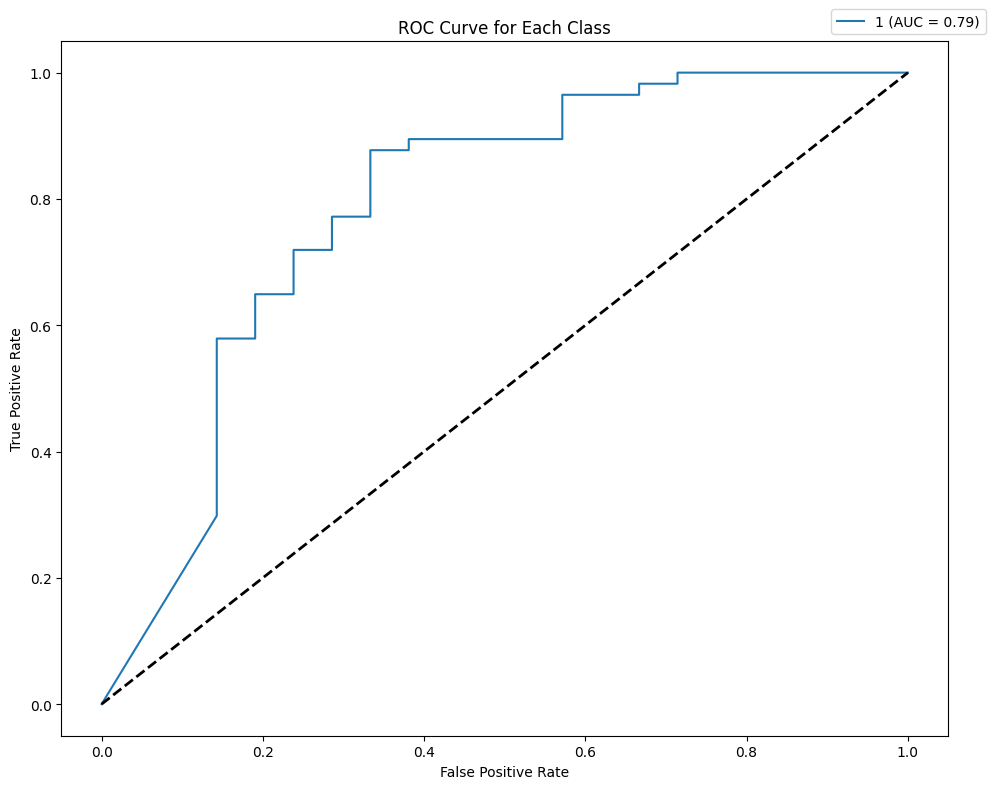

Classification Report for Train Set:
              precision    recall  f1-score   support

           0       0.42      0.78      0.55       147
           1       0.88      0.61      0.72       399

    accuracy                           0.65       546
   macro avg       0.65      0.69      0.63       546
weighted avg       0.76      0.65      0.67       546

Train Accuracy: 0.6538

Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       0.46      0.71      0.56        42
           1       0.87      0.69      0.77       114

    accuracy                           0.70       156
   macro avg       0.66      0.70      0.67       156
weighted avg       0.76      0.70      0.71       156

Validation Accuracy: 0.6987

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.45      0.81      0.58        21
           1       0.90      0.63      0.74        57

    accuracy  

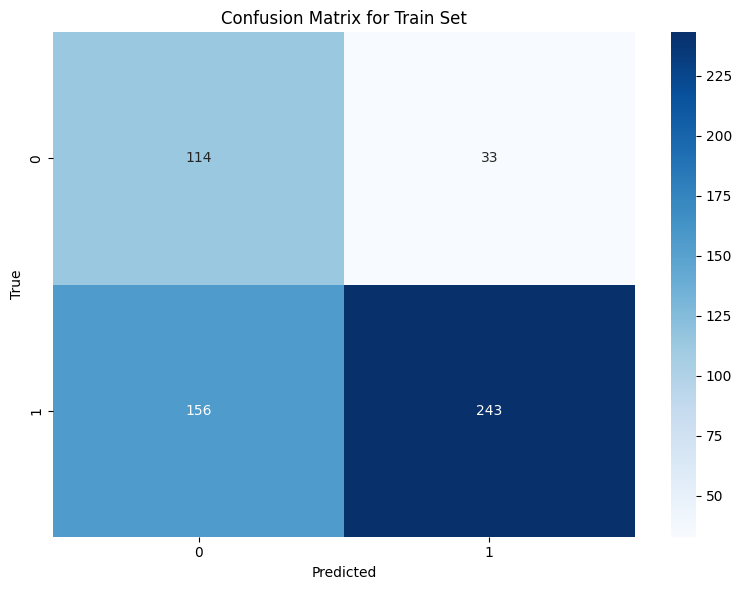

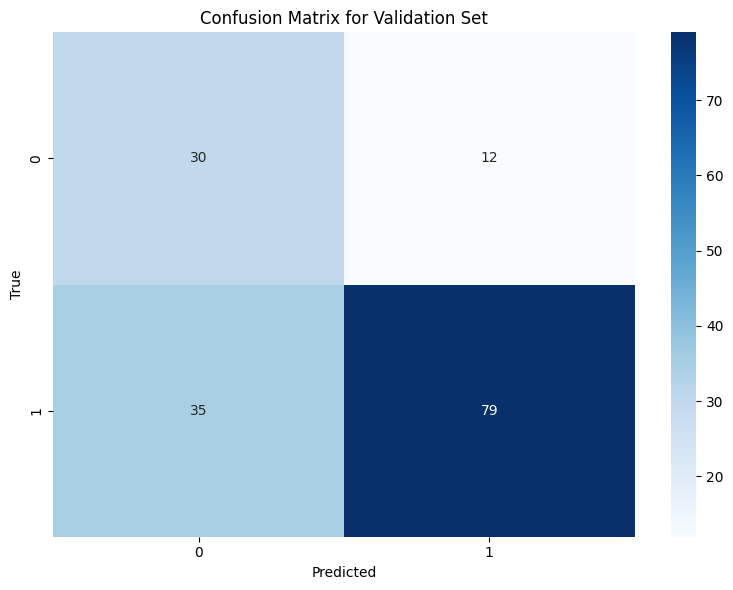

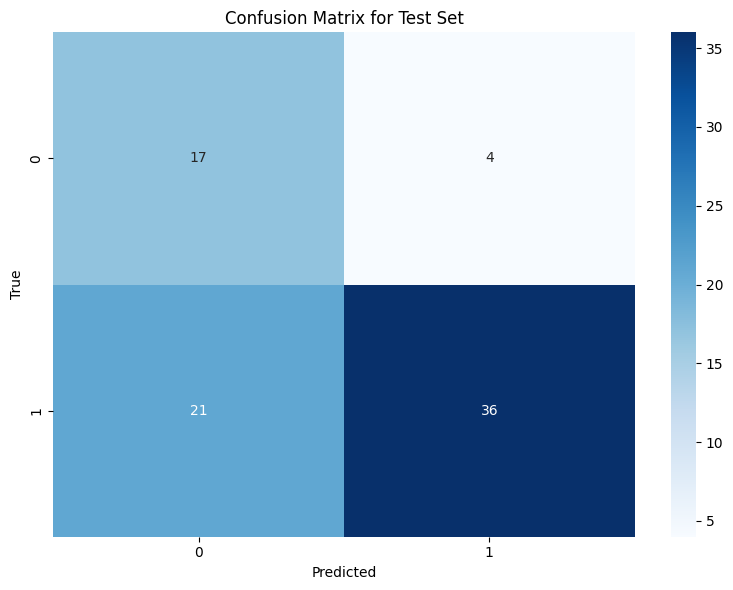

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.preprocessing import label_binarize

# Ελέγχουμε αν η class_names είναι ορισμένη. Αν όχι, τη δημιουργούμε
if 'class_names' not in locals():
    # Αν έχεις ήδη τον label_encoder, πάρε τα labels ως strings
    classes = getattr(label_encoder, 'classes_', None)
    # Αν το classes είναι None, scalar, ή 0-d array, το κάνουμε λίστα
    if classes is None:
        class_names = []
    elif isinstance(classes, (list, tuple)):
        class_names = [str(c) for c in classes]
    elif isinstance(classes, np.ndarray):
        if classes.shape == ():
            class_names = [str(classes.item())]
        else:
            class_names = [str(c) for c in classes]
    else:
        class_names = [str(classes)]
else:
    # Βεβαιωνόμαστε ότι το class_names είναι array-like (όχι scalar)
    if not isinstance(class_names, (list, tuple, np.ndarray)):
        class_names = [str(class_names)]
    # Αν είναι numpy scalar (π.χ. np.uint8), το κάνουμε λίστα
    elif isinstance(class_names, np.generic):
        class_names = [str(class_names.item())]

# Βεβαιωνόμαστε ότι το class_names είναι πάντα λίστα (ή array-like)
if not isinstance(class_names, (list, tuple, np.ndarray)):
    class_names = [str(class_names)]
elif isinstance(class_names, np.generic):
    class_names = [str(class_names.item())]

# Βρίσκουμε τον αριθμό των κατηγοριών από τα δεδομένα
num_classes = len(class_names)  # ή αν είναι ήδη γνωστό, βάλε τον αριθμό απευθείας

# Ελέγχουμε αν η συσκευή (device) είναι ορισμένη
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Υπολογισμός πιθανοτήτων για το test set
with torch.no_grad():
    outputs = best_model(X_test_tensor.to(device))  # Υπολογισμός εξόδου για το test set
    probs = torch.softmax(outputs, dim=1)  # Εφαρμογή softmax για πιθανότητες

y_pred_test = torch.argmax(probs, dim=1).cpu().numpy()


# Binarization των ετικετών για το ROC
if num_classes == 2:
    y_test_bin = label_binarize(y_test_tensor.cpu().numpy(), classes=[0, 1])
else:
    y_test_bin = label_binarize(y_test_tensor.cpu().numpy(), classes=np.arange(num_classes))

# Υπολογισμός ROC και AUC για κάθε κατηγορία
fpr = {}
tpr = {}
roc_auc = {}

if num_classes == 2:
    # Για δυαδική ταξινόμηση, χρησιμοποιούμε μόνο τη δεύτερη στήλη των πιθανοτήτων (θετική κλάση)
    fpr[1], tpr[1], _ = roc_curve(y_test_bin.ravel(), probs[:, 1].cpu().numpy())
    roc_auc[1] = auc(fpr[1], tpr[1])
else:
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i].cpu().numpy())
        roc_auc[i] = auc(fpr[i], tpr[i])

# Σχεδίαση ROC curves
plt.figure(figsize=(10, 8))
if num_classes == 2:
    # Μόνο για τη θετική κλάση (1) στη δυαδική ταξινόμηση
    plt.plot(fpr[1], tpr[1], label=f'{class_names[1]} (AUC = {roc_auc[1]:.2f})')
else:
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Διάσπαση για την τυχαία απόδοση
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

class_names = [str(c) for c in class_names]

# Εκτύπωση Classification Report για το Train Set
y_pred_train = torch.argmax(best_model(X_train_tensor.to(device)), dim=1).cpu().numpy()
print("Classification Report for Train Set:")
print(classification_report(y_train_tensor.cpu().numpy(), y_pred_train, target_names=class_names))
train_acc = accuracy_score(y_train_tensor.cpu().numpy(), y_pred_train)
print(f"Train Accuracy: {train_acc:.4f}")
print()

# Εκτύπωση Classification Report για το Validation Set
y_pred_val = torch.argmax(best_model(X_val_tensor.to(device)), dim=1).cpu().numpy()
print("Classification Report for Validation Set:")
print(classification_report(y_val_tensor.cpu().numpy(), y_pred_val, target_names=class_names))
val_acc = accuracy_score(y_val_tensor.cpu().numpy(), y_pred_val)
print(f"Validation Accuracy: {val_acc:.4f}")
print()

# Εκτύπωση Classification Report για το Test Set με τα ονόματα των κατηγοριών
y_pred_test = torch.argmax(probs, dim=1).cpu().numpy()  # Ταξινόμηση με τις μεγάλες πιθανότητες
print("Classification Report for Test Set:")
print(classification_report(y_test_tensor.cpu().numpy(), y_pred_test, target_names=class_names))
test_acc = accuracy_score(y_test_tensor.cpu().numpy(), y_pred_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix για το Train Set
conf_matrix_train = confusion_matrix(y_train_tensor.cpu().numpy(), y_pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Train Set")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Confusion Matrix για το Validation Set
conf_matrix_val = confusion_matrix(y_val_tensor.cpu().numpy(), y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Validation Set")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Confusion Matrix για το Test Set
conf_matrix_test = confusion_matrix(y_test_tensor.cpu().numpy(), y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Test Set")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()